In [3]:
import numpy as np
import pandas as pd
import time
from scipy.io import wavfile
from skimage import util
from scipy import signal

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold, train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV

from sklearn.cluster import KMeans
from sklearn.metrics.cluster import silhouette_score

#visualizing results
%matplotlib inline
#import seaborn as sns
import matplotlib.pyplot as plt
#import yellowbrick as yb

In [4]:
file_path = 'C:/Users/Schindler/Documents/Schindler_Lab/Data/USVs/CPA_pair_exp/18.12.07_CPA_pair_3x/535.wav'

In [5]:
def create_slice_from_wav(file_path, slice_len, step_size):
    """Creates small slices from wav file. Slice_len (use sampling frequency to convert to ms). 
    Step_size is amount of overlap between each slice."""
    
    #read in wav file
    samp_freq, sig_data = wavfile.read(file_path)
    print('Sampling frequency: ' + str(samp_freq))
    
    #determine number of samples and length
    n_samples = sig_data.shape[0]
    print('Number of samples: ' + str(n_samples))
    sig_len = n_samples/samp_freq
    print('Length: ' + str(sig_len) + ' sec')
    
    #create slices 
    M = slice_len
    steps = int(M*step_size)
    slices = util.view_as_windows(sig_data, window_shape=(M,), step=steps)
    print(f'Audio shape: {sig_data.shape}, Sliced audio shape: {slices.shape}')
    
    return samp_freq, sig_data, slices, steps

In [6]:
def create_spec_from_slice(sli, nperseg, nfft, i):
    """Creates spectrogram from individual slices. Sli = array of slices. nperseg = length of each segment.
    nftt = length of FFT used. i = slice index"""
    
    #create spectrogram
    freqs_spec, times, Sx = signal.spectrogram(sli, fs=samp_freq, nperseg = nperseg, nfft = nfft)
    
    return freqs_spec, times, Sx

In [7]:
def create_psd_from_slice(sli):
    """Creates spectrogram from individual slices. Sli = array of slices. nperseg = length of each segment.
    nftt = length of FFT used. i = slice index"""
    
    #create power spectral density using a periodogram
    freqs_psd, Px = signal.periodogram(sli, fs=samp_freq)
    
    return freqs_psd, Px

In [8]:
def plot_spec(Sx, times, steps, i):
    """Plots a spectrogram from a slice"""
    
    f, ax = plt.subplots()
    plt.pcolormesh((times*1000) + (i*steps/250), freqs_spec / 1000, 10 * np.log10(Sx))
    ax.ticklabel_format(useOffset=False)
    plt.ylabel('Frequency [kHz]')
    plt.xlabel('Time [msec]')
    plt.show()
    
    return plt

In [9]:
def plot_psd(Px, freqs_psd):
    """Plots power spectral density from a slice"""
    
    f, ax = plt.subplots()
    plt.semilogy(freqs_psd, np.log10(Px))
    plt.xlabel('frequency [Hz]')
    plt.ylabel('PSD [V**2/Hz]')
    plt.show()
    
    return plt

In [10]:
samp_freq, sig_data, slices, steps = create_slice_from_wav(file_path, 25000, 0.5)

Sampling frequency: 250000
Number of samples: 180748288
Length: 722.993152 sec
Audio shape: (180748288,), Sliced audio shape: (14458, 25000)


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log10
  """


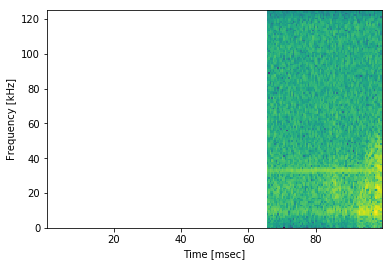

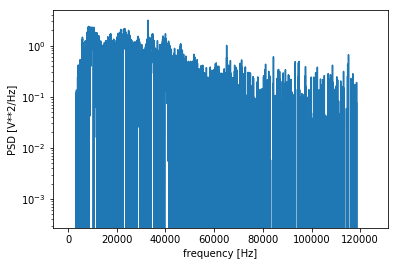

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in log10


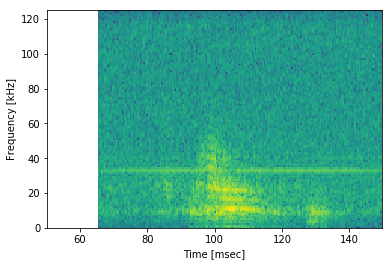

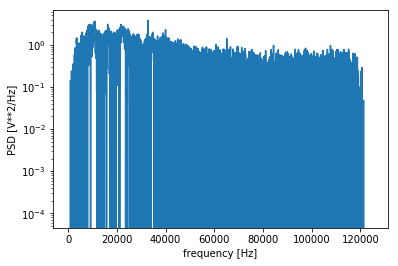

2.631464958190918


In [11]:
start = time.time()
i = 0
spec_slices = {}
spec_slices_ravel = {}
psd_slices = {}
psd_slices_ravel = {}

for sli in slices[0:2]:
    
    #spectrogram
    freqs_spec, times, Sx = create_spec_from_slice(sli, 128, 256, i)
    
    #psd
    freqs_psd, Px = create_psd_from_slice(sli)
    
    #plot spectrogram
    plt_spec = plot_spec(Sx, times, steps, i)
    
    #plot spd
    plt_psd = plot_psd(Px, freqs_psd)
    
    spec_slices[i] = np.log10(Sx)
    spec_slices_ravel[i] = spec_slices[i].ravel().T
    
    psd_slices[i] = np.log10(Px)
    psd_slices_ravel[i] = Px[i].ravel().T
    
    i = i + 1
    
end = time.time()
print(end - start)

In [ ]:
freqs_psd_whole, Px_whole = create_psd_from_slice(sig_data)

In [ ]:
np.mean(psd_slices)

In [12]:
spec_slices_df = pd.DataFrame(spec_slices_ravel).T
spec_slices_df.head()

,0,1,2,3,4,5,6,7,8,9,...,28757,28758,28759,28760,28761,28762,28763,28764,28765,28766
0,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,...,-1.458534,-0.802459,-1.532968,-0.810350,-1.597372,-0.556064,-1.051143,-1.501265,-1.315851,-1.364023
1,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,...,-1.084045,-1.436597,-0.973054,-0.615129,-1.894219,-1.103745,-1.389089,-1.787634,-1.828749,-3.190127


In [ ]:
spec_slices_df.drop([0,1], axis = 0, inplace = True)

In [ ]:
print(spec_slices_df.shape)
spec_slices_df.info()

In [ ]:
# center and scale the data
scaler = StandardScaler()
slices_scaled = scaler.fit_transform(spec_slices_df)

In [ ]:
k_range = range(2,20)
scores = []
for k in k_range:
    km_ss = KMeans(n_clusters=k, random_state=1)
    km_ss.fit(slices_scaled)
    scores.append(silhouette_score(slices_scaled, km_ss.labels_))

# plot the results
plt.plot(k_range, scores)
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Coefficient')

In [ ]:
km2 = KMeans(n_clusters=3,random_state=1234)
km2.fit(slices_scaled)
score = silhouette_score(slices_scaled, km_ss.labels_)
#summary_ave['kmeans_2_scaled'] = [ "cluster_" + str(label) for label in km2.labels_ ]
#summary_ave.groupby('kmeans_2_scaled').mean()
print(score)